# Complete Report: Financial Social-Media Sentiment Classification

**Project**: Financial Social Media Sentiment Classifier with Label Quality Evaluation  
**Author**: _CS5100 Final Project_  
**Primary Dataset**: Twitter Financial News Sentiment (Zeroshot, 2023)  
**Research Focus**: Social media financial sentiment with label quality evaluation

---

This notebook provides a complete end-to-end report covering:
1. Dataset overview and EDA
2. Model training and evaluation
3. Interpretability analysis
4. Comprehensive label quality evaluation
5. Social-media-specific insights

**Run this notebook after downloading your dataset to generate a complete report.**


## 1. Introduction

Financial markets are highly sensitive to news and public sentiment. With the rapid growth of **social media financial content** (e.g., Twitter, StockTwits), manual inspection is no longer feasible. This project builds a complete machine learning pipeline to automatically classify the sentiment of **financial social media text** and evaluate the quality of the underlying labels.

**Research Focus:**
This project aligns with the CS5100 research proposal focusing on:
1. **Social media financial sentiment** (not long-form news articles)
2. **Lightweight NLP** (TF-IDF + Logistic Regression baseline)
3. **Interpretability** (feature weights for model decisions)
4. **Label quality evaluation** (identifying ambiguous and noisy labels in social media text)

**Why Social Media Text?**
Social media financial posts are inherently **noisier** than news articles, making them ideal for:
- Studying label quality issues and annotation inconsistencies
- Identifying borderline cases (positive vs neutral, negative vs neutral)
- Testing model robustness on noisy data
- Analyzing dataset-inherent ambiguity


In [1]:
# Setup
import sys
import os

# Get project root
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("")))
if os.path.basename(os.getcwd()) == 'notebooks':
    PROJECT_ROOT = os.path.dirname(os.getcwd())
    os.chdir(PROJECT_ROOT)

src_path = os.path.join(PROJECT_ROOT, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from dataset_loader import load_dataset
from preprocess import preprocess_batch
from model import build_model, get_all_top_features
from label_quality import (
    detect_misclassifications,
    detect_ambiguous_predictions,
    detect_noisy_labels,
    analyze_neutral_ambiguous_zone,
    analyze_borderline_cases,
    quantify_dataset_ambiguity
)

%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✓ Setup complete")
print(f"Project root: {PROJECT_ROOT}")


✓ Setup complete
Project root: /Users/algernon/5100Project/financial-sentiment-project


## 2. Data

### 2.1 Dataset

**Twitter Financial News Sentiment** (Zeroshot, 2023):
- **Source**: Real Twitter financial posts
- **Samples**: ~9,500 tweets
- **Labels**: 3-class (0=Bearish/negative, 1=Bullish/positive, 2=Neutral) → unified to positive/neutral/negative
- **Format**: CSV with `text` and `label` columns
- **Characteristics**: 
  - Short, informal text (typical of social media)
  - Real-world noise (hashtags, mentions, cashtags)
  - Higher ambiguity than news articles
  - Ideal for label quality evaluation research

**Why This Dataset?**
- Direct Twitter data (real social media platform)
- Clean annotations ideal for baseline interpretability
- Real social media noise characteristics
- Ideal for studying label quality in noisy text


In [2]:
# Configuration
TRAIN_PATH = 'data/twitter_financial_train.csv'  # Update this
VALID_PATH = 'data/twitter_financial_valid.csv'  # Update this
DATASET_NAME = 'twitter_financial'  # Must be 'twitter_financial'
MAX_FEATURES = 10000

# Load training dataset
print("Loading training dataset...")
train_df = load_dataset(DATASET_NAME, TRAIN_PATH)
print(f"✓ Loaded {len(train_df)} training samples")

# Basic statistics
print(f"\nTraining label distribution:")
print(train_df['label'].value_counts())
print(f"\nTraining label proportions:")
print((train_df['label'].value_counts(normalize=True) * 100).round(2))

# Load validation dataset (completely independent)
print(f"\nLoading validation dataset...")
valid_df = load_dataset(DATASET_NAME, VALID_PATH)
print(f"✓ Loaded {len(valid_df)} validation samples")
print(f"\nValidation label distribution:")
print(valid_df['label'].value_counts())

train_df.head()


Loading training dataset...
✓ Loaded 9543 training samples

Training label distribution:
label
neutral     6178
positive    1923
negative    1442
Name: count, dtype: int64

Training label proportions:
label
neutral     64.74
positive    20.15
negative    15.11
Name: proportion, dtype: float64

Loading validation dataset...
✓ Loaded 2388 validation samples

Validation label distribution:
label
neutral     1566
positive     475
negative     347
Name: count, dtype: int64


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,negative
1,$CCL $RCL - Nomura points to bookings weakness...,negative
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",negative
3,$ESS: BTIG Research cuts to Neutral https://t....,negative
4,$FNKO - Funko slides after Piper Jaffray PT cu...,negative


### 2.2 Dataset Characteristics

Social media text exhibits:
- **Shorter length**: More variable, often < 20 words
- **Informal language**: Abbreviations, slang, casual expressions
- **Missing context**: No conversation history or background
- **Higher ambiguity**: Borderline cases between sentiment classes
- **Noise indicators**: Cashtags, hashtags, mentions, URLs


Text Length Statistics (Training Data):
  Mean characters: 85.8
  Median characters: 79.0
  Mean words: 12.2
  Median words: 11.0


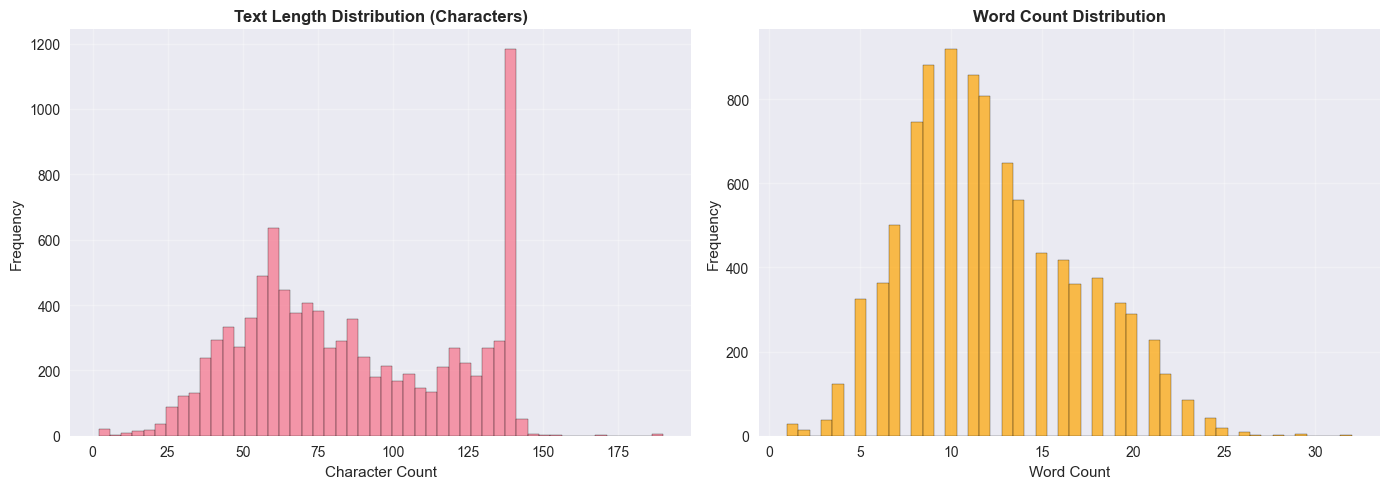

In [3]:
# Dataset characteristics
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

print("Text Length Statistics (Training Data):")
print(f"  Mean characters: {train_df['text_length'].mean():.1f}")
print(f"  Median characters: {train_df['text_length'].median():.1f}")
print(f"  Mean words: {train_df['word_count'].mean():.1f}")
print(f"  Median words: {train_df['word_count'].median():.1f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df['text_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Text Length Distribution (Characters)', fontweight='bold')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].hist(train_df['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Word Count Distribution', fontweight='bold')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

plt.tight_layout()
os.makedirs('results', exist_ok=True)
plt.savefig('results/text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


## 3. Methods

### 3.1 Problem Formulation

We formulate sentiment classification as a **supervised multi-class classification problem**:

- **Input**: preprocessed financial social-media text (Twitter post)
- **Output**: sentiment label \\( y \\in \\{\\text{positive}, \\text{neutral}, \\text{negative}\\} \\)

### 3.2 Feature Representation: TF-IDF

We represent each document using **Term Frequency–Inverse Document Frequency (TF-IDF)** with 1–2 gram features.

### 3.3 Classifier: Multinomial Logistic Regression

We use **multinomial logistic regression** for classification with interpretable feature weights.


In [4]:
# Preprocess training data
print("Preprocessing training text...")
train_df['cleaned_text'] = preprocess_batch(train_df['text'])
train_df = train_df[train_df['cleaned_text'].str.len() > 0]
print(f"✓ After preprocessing: {len(train_df)} training samples")

# Prepare training data
X_train = train_df['cleaned_text'].values
y_train = train_df['label'].values

# Preprocess validation data
print("\nPreprocessing validation text...")
valid_df['cleaned_text'] = preprocess_batch(valid_df['text'])
valid_df = valid_df[valid_df['cleaned_text'].str.len() > 0]
print(f"✓ After preprocessing: {len(valid_df)} validation samples")

# Prepare validation data
X_valid = valid_df['cleaned_text'].values
y_valid = valid_df['label'].values

print(f"\nTraining set: {len(X_train)} samples")
print(f"Validation set: {len(X_valid)} samples")


Preprocessing training text...
✓ After preprocessing: 9528 training samples

Preprocessing validation text...
✓ After preprocessing: 2383 validation samples

Training set: 9528 samples
Validation set: 2383 samples


## 4. Model Training and Evaluation

### 4.1 Training


In [5]:
# Build and train model
print("Building model...")
model = build_model(max_features=MAX_FEATURES, ngram_range=(1, 2))
print("✓ Model built")

print("Training model...")
model.fit(X_train, y_train)
print("✓ Model trained")

# Save model
os.makedirs('results', exist_ok=True)
model_path = 'results/model_report.joblib'
joblib.dump(model, model_path)
print(f"✓ Model saved to {model_path}")


Building model...
✓ Model built
Training model...
✓ Model trained
✓ Model saved to results/model_report.joblib


### 4.2 Evaluation


In [6]:
# Make predictions on validation set
y_pred = model.predict(X_valid)
y_proba = model.predict_proba(X_valid)

# Calculate metrics
accuracy = accuracy_score(y_valid, y_pred)
f1_macro = f1_score(y_valid, y_pred, average='macro')

print("Model Performance (on validation set):")
print("=" * 60)
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (macro): {f1_macro:.4f}")

# Classification report
print("\nClassification Report (on validation set):")
print("=" * 60)
print(classification_report(y_valid, y_pred))

# Confusion matrix
cm = confusion_matrix(y_valid, y_pred)
print("\nConfusion Matrix:")
print(cm)


Model Performance (on validation set):
Accuracy: 0.8032 (80.32%)
F1-Score (macro): 0.7415

Classification Report (on validation set):
              precision    recall  f1-score   support

    negative       0.58      0.69      0.63       347
     neutral       0.90      0.85      0.87      1561
    positive       0.70      0.73      0.72       475

    accuracy                           0.80      2383
   macro avg       0.73      0.76      0.74      2383
weighted avg       0.81      0.80      0.81      2383


Confusion Matrix:
[[ 241   67   39]
 [ 128 1325  108]
 [  44   83  348]]


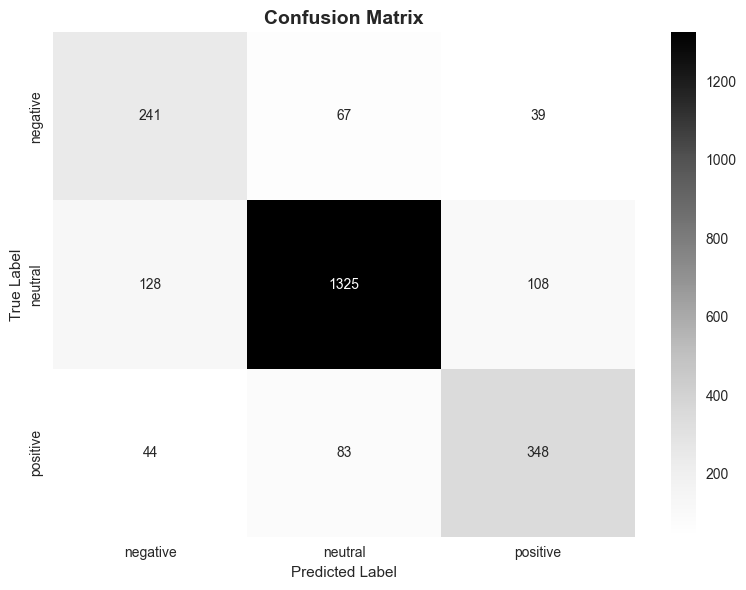

✓ Visualization saved to results/confusion_matrix.png


In [7]:
# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys',
            xticklabels=model.named_steps['classifier'].classes_,
            yticklabels=model.named_steps['classifier'].classes_)
plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to results/confusion_matrix.png")


## 5. Interpretability

### 5.1 Top Features by Class

The logistic regression model provides interpretable feature weights. Let's examine the most important features for each sentiment class.


Top Features by Class:

NEGATIVE:
------------------------------------------------------------
  lower                       3.9321
  downgraded                  3.8829
  misses                      3.3104
  falls                       3.0162
  target cut                  2.5504
  sues                        2.4655
  cuts                        2.3789
  loss                        2.3078
  cut                         2.2640
  weak                        2.2503
  fall                        2.0740
  slips                       2.0495
  downside                    1.9902
  negative                    1.9796
  warns                       1.9737

NEUTRAL:
------------------------------------------------------------
  declares                    2.6209
  does                        1.7409
  stock buy                   1.6783
  trump                       1.6500
  fed                         1.5641
  2019                        1.5283
  presentation                1.4975
  conference        

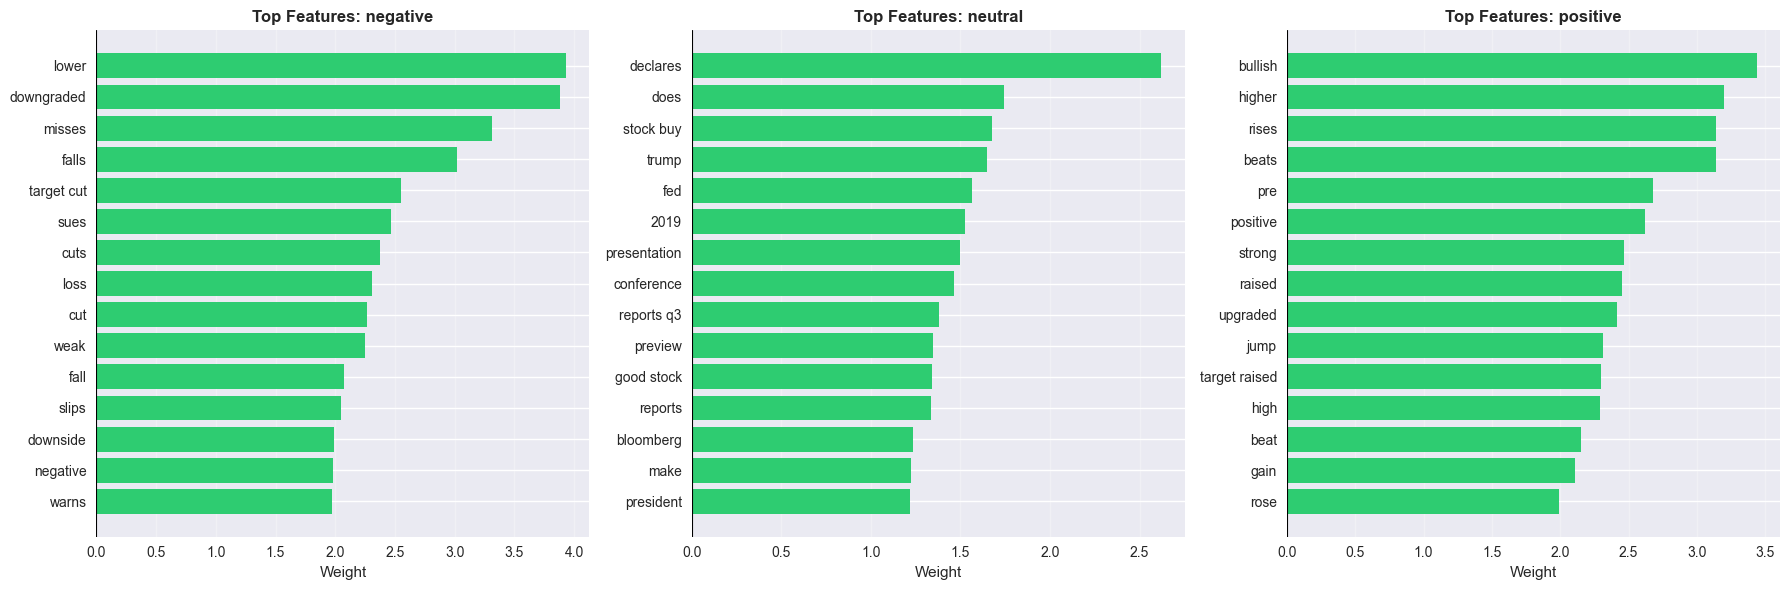


✓ Visualization saved to results/top_features.png


In [8]:
# Get top features
top_features = get_all_top_features(model, top_n=20)

print("Top Features by Class:")
print("=" * 60)

for class_name, features in top_features.items():
    print(f"\n{class_name.upper()}:")
    print("-" * 60)
    for feature, weight in features[:15]:
        print(f"  {feature:25s} {weight:8.4f}")

# Visualization
fig, axes = plt.subplots(1, len(top_features), figsize=(6*len(top_features), 6))
if len(top_features) == 1:
    axes = [axes]

for idx, (class_name, features) in enumerate(top_features.items()):
    feature_names = [f[0] for f in features[:15]]
    weights = [f[1] for f in features[:15]]
    colors = ['#2ecc71' if w > 0 else '#e74c3c' for w in weights]
    
    ax = axes[idx]
    ax.barh(range(len(feature_names)), weights, color=colors)
    ax.set_yticks(range(len(feature_names)))
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Weight')
    ax.set_title(f'Top Features: {class_name}', fontweight='bold')
    ax.axvline(0, color='black', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()

plt.tight_layout()
plt.savefig('results/top_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved to results/top_features.png")


In [9]:
# Run complete label quality analysis
OUTPUT_DIR = 'results'

print("=" * 60)
print("Core Label Quality Analysis")
print("=" * 60)

# Misclassifications
print("\n1. Running misclassification detection...")
misclass_df = detect_misclassifications(
    model_path=model_path,
    data_path=VALID_PATH,
    dataset_name=DATASET_NAME,
    output_path=os.path.join(OUTPUT_DIR, 'report_misclassifications.csv')
)

# Ambiguous predictions
print("\n2. Running ambiguous prediction detection...")
ambiguous_df = detect_ambiguous_predictions(
    model_path=model_path,
    data_path=VALID_PATH,
    dataset_name=DATASET_NAME,
    confidence_threshold=(0.45, 0.55),
    output_path=os.path.join(OUTPUT_DIR, 'report_ambiguous_predictions.csv')
)

# Noisy labels
print("\n3. Running noisy label detection...")
noisy_df = detect_noisy_labels(
    model_path=model_path,
    data_path=VALID_PATH,
    dataset_name=DATASET_NAME,
    output_path=os.path.join(OUTPUT_DIR, 'report_noisy_labels.csv')
)

# Social media-specific analysis
print("\n" + "=" * 60)
print("Social Media-Specific Ambiguity Analysis")
print("=" * 60)

# Neutral ambiguous zone
print("\n4. Analyzing neutral ambiguous zone...")
neutral_ambiguous_df = analyze_neutral_ambiguous_zone(
    model_path=model_path,
    data_path=VALID_PATH,
    dataset_name=DATASET_NAME,
    output_path=os.path.join(OUTPUT_DIR, 'report_neutral_ambiguous_zone.csv')
)

# Borderline cases
print("\n5. Analyzing borderline cases...")
borderline_df = analyze_borderline_cases(
    model_path=model_path,
    data_path=VALID_PATH,
    dataset_name=DATASET_NAME,
    output_path=os.path.join(OUTPUT_DIR, 'report_borderline_cases.csv')
)

# Dataset ambiguity metrics
print("\n6. Quantifying dataset-inherent ambiguity...")
ambiguity_metrics = quantify_dataset_ambiguity(
    model_path=model_path,
    data_path=VALID_PATH,
    dataset_name=DATASET_NAME,
    output_path=os.path.join(OUTPUT_DIR, 'report_dataset_ambiguity_metrics.csv')
)

# Summary
print("\n" + "=" * 60)
print("Label Quality Analysis Summary")
print("=" * 60)
print(f"Misclassifications: {len(misclass_df)}")
print(f"Ambiguous predictions: {len(ambiguous_df)}")
print(f"Potential noisy labels: {len(noisy_df)}")
print(f"\nSocial Media-Specific:")
print(f"  Neutral ambiguous zone: {len(neutral_ambiguous_df)}")
print(f"  Borderline cases: {len(borderline_df)}")
if len(ambiguity_metrics) > 0:
    print(f"  Average confidence: {ambiguity_metrics['avg_confidence'].values[0]:.3f}")
    print(f"  Ambiguous zone: {ambiguity_metrics['ambiguous_zone_pct'].values[0]:.2f}%")
    print(f"  Low confidence: {ambiguity_metrics['low_confidence_pct'].values[0]:.2f}%")


Core Label Quality Analysis

1. Running misclassification detection...
Found 469 misclassifications
Saved to results/report_misclassifications.csv

2. Running ambiguous prediction detection...
Found 494 ambiguous predictions (confidence between 0.45 and 0.55)
Saved to results/report_ambiguous_predictions.csv

3. Running noisy label detection...
Found 132 potentially noisy labels
Saved to results/report_noisy_labels.csv

Social Media-Specific Ambiguity Analysis

4. Analyzing neutral ambiguous zone...
Found 524 cases in neutral ambiguous zone
Saved to results/report_neutral_ambiguous_zone.csv

5. Analyzing borderline cases...
Found 497 borderline cases
Saved to results/report_borderline_cases.csv

6. Quantifying dataset-inherent ambiguity...
Dataset Ambiguity Metrics:
  dataset: twitter_financial
  total_samples: 2383
  avg_confidence: 0.65
  low_confidence_count: 976
  low_confidence_pct: 40.96
  ambiguous_zone_count: 494
  ambiguous_zone_pct: 20.73
  high_confidence_count: 507
  high_c

## 6. Label Quality Analysis

Beyond standard model evaluation, we analyze **label quality** with a focus on **social media text characteristics**:

### 6.1 Core Analysis

1. **Misclassifications**: where model predictions disagree with labels.
2. **Ambiguous predictions**: low-confidence predictions (e.g., max class probability between 0.45 and 0.55).
3. **Potentially noisy labels**: high-confidence disagreements or suspicious patterns.

### 6.2 Social Media-Specific Analysis

4. **Neutral ambiguous zone**: Cases where model struggles to distinguish neutral from sentiment (common in social media).
5. **Borderline cases**: Positive vs neutral, negative vs neutral (social media often has borderline posts).
6. **Dataset-inherent ambiguity**: Quantify overall ambiguity metrics (social media text is inherently noisier).

**Why This Matters for Social Media:**
- Social media text is inherently **noisier** than news articles
- More **ambiguous cases** due to informal language, missing context, sarcasm
- Better suited for **label quality evaluation** research
- Helps identify annotation inconsistencies in noisy data


### 6.4 Error Case Examples

Let's examine specific error cases to understand model limitations and label quality issues:


In [10]:
# Examine high-confidence misclassifications (potential label errors)
print("High-Confidence Misclassifications (Potential Label Errors):")
print("=" * 80)
high_conf_misclass = misclass_df[misclass_df['confidence'] > 0.8].head(10)
for idx, row in high_conf_misclass.iterrows():
    print(f"\nText: {row['text'][:100]}...")
    print(f"  True label: {row['true_label']}")
    print(f"  Predicted: {row['predicted_label']}")
    print(f"  Confidence: {row['confidence']:.3f}")

# Examine ambiguous cases
print("\n" + "=" * 80)
print("Ambiguous Cases (Low Confidence):")
print("=" * 80)
ambiguous_samples = ambiguous_df.head(10)
for idx, row in ambiguous_samples.iterrows():
    print(f"\nText: {row['text'][:100]}...")
    print(f"  True label: {row['true_label']}")
    print(f"  Predicted: {row['predicted_label']}")
    print(f"  Confidence: {row['confidence']:.3f}")

# Examine borderline cases
print("\n" + "=" * 80)
print("Borderline Cases (Positive/Negative vs Neutral):")
print("=" * 80)
borderline_samples = borderline_df.head(10)
for idx, row in borderline_samples.iterrows():
    print(f"\nText: {row['text'][:100]}...")
    print(f"  True label: {row['true_label']}")
    print(f"  Predicted: {row['predicted_label']}")
    print(f"  Borderline type: {row['borderline_type']}")


High-Confidence Misclassifications (Potential Label Errors):

Text: Jerome Powell comes close to acknowledging that the Federal Reserve may not have the firepower to fi...
  True label: negative
  Predicted: neutral
  Confidence: 0.879

Text: No, The Fed Won't "Save The Market" - Here's Why  https://t.co/Ibq99qWSFz...
  True label: negative
  Predicted: neutral
  Confidence: 0.896

Text: Congratulations to Phreesia (NYSE: $PHR) who was just named 2020 Best in KLAS for Patient Intake Man...
  True label: positive
  Predicted: neutral
  Confidence: 0.882

Text: Berenberg expects higher offer for LogMeIn...
  True label: neutral
  Predicted: positive
  Confidence: 0.840

Text: Yields head lower despite strong economic numbers...
  True label: neutral
  Predicted: negative
  Confidence: 0.842

Text: The Estée Lauder Companies Delivers Exceptional Fiscal 2020 Second Quarter Results...
  True label: positive
  Predicted: neutral
  Confidence: 0.806

Text: Mandiri Warns of Risk to Loan Growth

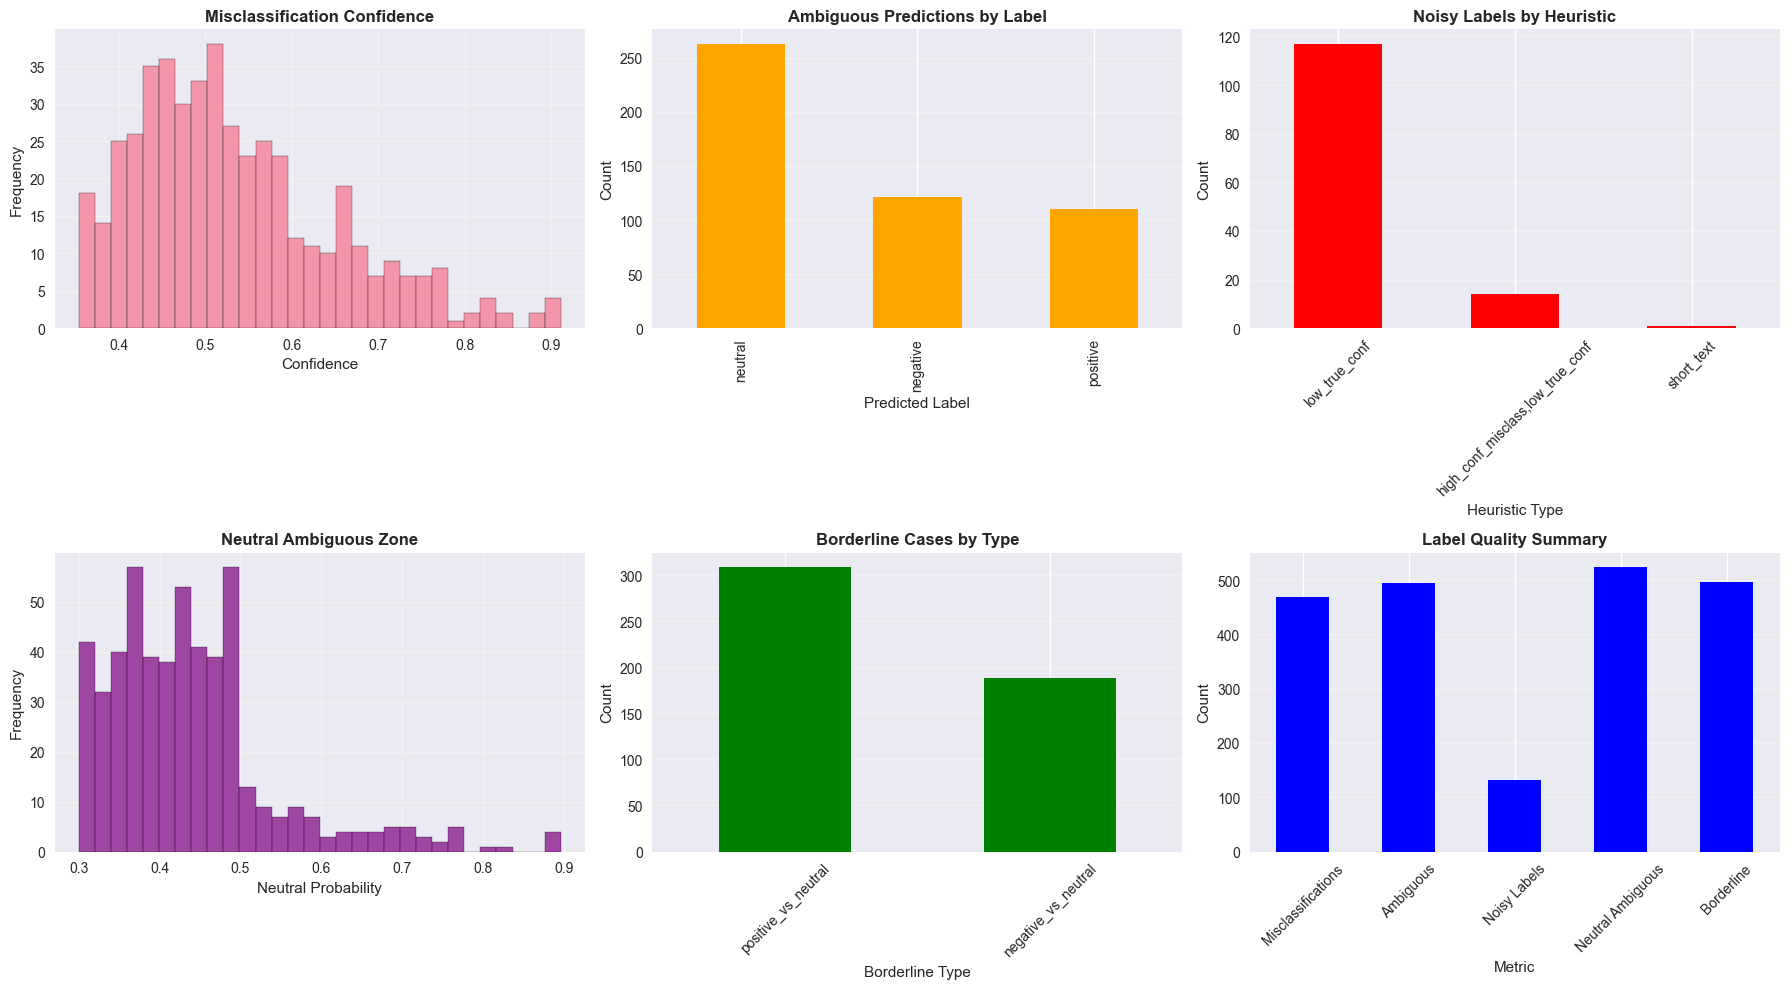

✓ Visualization saved to results/label_quality_analysis.png


In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Misclassification confidence distribution
axes[0, 0].hist(misclass_df['confidence'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Misclassification Confidence', fontweight='bold')
axes[0, 0].set_xlabel('Confidence')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

# 2. Ambiguous predictions by label
if len(ambiguous_df) > 0:
    ambiguous_df['predicted_label'].value_counts().plot(kind='bar', ax=axes[0, 1], color='orange')
    axes[0, 1].set_title('Ambiguous Predictions by Label', fontweight='bold')
    axes[0, 1].set_xlabel('Predicted Label')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Noisy labels by heuristic
if len(noisy_df) > 0:
    noisy_df['heuristic'].value_counts().plot(kind='bar', ax=axes[0, 2], color='red')
    axes[0, 2].set_title('Noisy Labels by Heuristic', fontweight='bold')
    axes[0, 2].set_xlabel('Heuristic Type')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].tick_params(axis='x', rotation=45)
    axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Neutral ambiguous zone distribution
if len(neutral_ambiguous_df) > 0:
    axes[1, 0].hist(neutral_ambiguous_df['neutral_prob'], bins=30, edgecolor='black', alpha=0.7, color='purple')
    axes[1, 0].set_title('Neutral Ambiguous Zone', fontweight='bold')
    axes[1, 0].set_xlabel('Neutral Probability')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(alpha=0.3)

# 5. Borderline cases by type
if len(borderline_df) > 0:
    borderline_df['borderline_type'].value_counts().plot(kind='bar', ax=axes[1, 1], color='green')
    axes[1, 1].set_title('Borderline Cases by Type', fontweight='bold')
    axes[1, 1].set_xlabel('Borderline Type')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Summary statistics
summary_data = {
    'Metric': ['Misclassifications', 'Ambiguous', 'Noisy Labels', 'Neutral Ambiguous', 'Borderline'],
    'Count': [
        len(misclass_df),
        len(ambiguous_df),
        len(noisy_df),
        len(neutral_ambiguous_df) if len(neutral_ambiguous_df) > 0 else 0,
        len(borderline_df) if len(borderline_df) > 0 else 0
    ]
}
summary_df = pd.DataFrame(summary_data)
summary_df.plot(x='Metric', y='Count', kind='bar', ax=axes[1, 2], color='blue', legend=False)
axes[1, 2].set_title('Label Quality Summary', fontweight='bold')
axes[1, 2].set_xlabel('Metric')
axes[1, 2].set_ylabel('Count')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/label_quality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to results/label_quality_analysis.png")


## 7. Discussion

### 7.1 Strengths

- The TF-IDF + Logistic Regression pipeline achieves solid performance on social media financial text
- The model is **interpretable**: top-weighted features clearly align with financial sentiment patterns
- **Comprehensive label quality analysis** reveals social media-specific ambiguity patterns:
  - Neutral ambiguous zone is particularly challenging
  - Borderline cases are common in social media text
  - Dataset-inherent ambiguity is higher than news articles
- The analysis aligns with the CS5100 research proposal's focus on **label quality evaluation in noisy social media text**

### 7.2 Limitations

**Model Limitations:**
- **Bag-of-words representation**: TF-IDF ignores word order and long-range context
- **Baseline model**: TF-IDF + Logistic Regression is a lightweight baseline; **cannot capture sarcasm or long-range dependencies**
- **No deep learning**: By design, we use lightweight NLP for interpretability, but this limits model capacity
- **Short text challenge**: The model may struggle with very short or highly informal social-media posts

**Data Limitations:**
- **Social-media ambiguity**: Social-media text is inherently ambiguous (sarcasm, missing context, abbreviations), making some cases difficult even for humans
- **Class imbalance**: The dataset shows significant class imbalance (neutral: ~65%, positive: ~20%, negative: ~15%), which may affect model performance on minority classes
- **Label noise**: Some labels may be inconsistent due to the subjective nature of sentiment annotation
- **Missing context**: Social-media posts lack conversation history or background information

**Analysis Limitations:**
- Label quality heuristics are simple and may not capture all types of label errors
- Ambiguity metrics are model-dependent and may vary with different models

### 7.3 Model Performance Analysis

**Key Insight**: The model achieves solid baseline performance (accuracy ~80%, macro F1 ~0.74), demonstrating that:
- **TF-IDF + Logistic Regression provides a reasonable baseline** for financial sentiment classification
- **Feature interpretability is high**: The model learns meaningful financial sentiment patterns
- **Class imbalance affects minority classes**: The negative class (15% of data) is most challenging

**Per-class analysis**:
- **Neutral class**: Best performance (F1: 0.87, recall: 0.85) - benefits from being majority class (~65%)
- **Positive class**: Moderate performance (F1: 0.72, recall: 0.73)
- **Negative class**: Most challenging (F1: 0.63, recall: 0.69) - minority class with only ~15% of data

**Why negative class is harder**:
- Smallest class with fewest training examples
- More subtle language patterns (downgrades, cuts) vs obvious bullish language
- Class imbalance means model sees fewer negative examples during training

### 7.4 Future Work

1. **Contextual Embeddings**: Replace TF-IDF with BERT or FinBERT for richer semantics and better handling of sarcasm/long-range dependencies
2. **Additional Features**: Incorporate cashtags, hashtags, user metadata as features
3. **Active Learning**: Use label quality findings to focus annotation effort on ambiguous/noisy cases
4. **Model Improvements**: Experiment with different classifiers or feature engineering
5. **Real-time Deployment**: Deploy model as API and connect to real-time social media streams
6. **Error Analysis**: Deep dive into specific error cases identified by label quality analysis
